# Training machine learning models on tabular data: an end-to-end example (non-Unity Catalog)

This tutorial covers the following steps:
- Visualize the data using Seaborn and matplotlib
- Run a parallel hyperparameter sweep to train multiple models
- Explore hyperparameter sweep results with MLflow
- Register the best performing model in MLflow
- Apply the registered model to another dataset using a Spark UDF

In this example, you build a model to predict the quality of Portuguese "Vinho Verde" wine based on the wine's physicochemical properties. 

The example uses a dataset from the UCI Machine Learning Repository, presented in [*Modeling wine preferences by data mining from physicochemical properties*](https://www.sciencedirect.com/science/article/pii/S0167923609001377?via%3Dihub) [Cortez et al., 2009].

## Requirements
This notebook requires a cluster running Databricks Runtime 15.4 LTS ML or above.

If your workspace is enabled for Unity Catalog, do not use this notebook. A version for workspaces that are enabled for Unity Catalog is available: ([AWS](https://docs.databricks.com/mlflow/end-to-end-example.html) | [Azure](https://docs.microsoft.com/azure/databricks/mlflow/end-to-end-example) | [GCP](https://docs.gcp.databricks.com/mlflow/end-to-end-example.html)).

## Read the data
Read the white wine quality and red wine quality CSV datasets and merge them into a single DataFrame.

In [0]:
import pandas as pd

# URL del archivo CSV en GitHub
url = 'https://raw.githubusercontent.com/stedy/Machine-Learning-with-R-datasets/master/winequality-white.csv'
url_red = 'https://github.com/aniruddhachoudhury/Red-Wine-Quality/blob/master/winequality-red.csv'

# Leer el archivo CSV desde la URL en un DataFrame de pandas
white_wine = pd.read_csv(url)
red_wine = pd.read_csv(url)

# Mostrar las primeras filas del DataFrame
print(white_wine.head())

   fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.0              0.27         0.36  ...       0.45      8.8        6
1            6.3              0.30         0.34  ...       0.49      9.5        6
2            8.1              0.28         0.40  ...       0.44     10.1        6
3            7.2              0.23         0.32  ...       0.40      9.9        6
4            7.2              0.23         0.32  ...       0.40      9.9        6

[5 rows x 12 columns]


Merge the two DataFrames into a single dataset, with a new binary feature "is_red" that indicates whether the wine is red or white.

In [0]:
red_wine['is_red'] = 1
white_wine['is_red'] = 0

data = pd.concat([red_wine, white_wine], axis=0)

# Remove spaces from column names
data.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

In [0]:
data.head()

fixed_acidity  volatile_acidity  citric_acid  ...  alcohol  quality  is_red
0            7.0              0.27         0.36  ...      8.8        6       1
1            6.3              0.30         0.34  ...      9.5        6       1
2            8.1              0.28         0.40  ...     10.1        6       1
3            7.2              0.23         0.32  ...      9.9        6       1
4            7.2              0.23         0.32  ...      9.9        6       1

[5 rows x 13 columns]

## Visualize data

Before training a model, explore the dataset using Seaborn and Matplotlib.

Plot a histogram of the dependent variable, quality.

/databricks/python/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


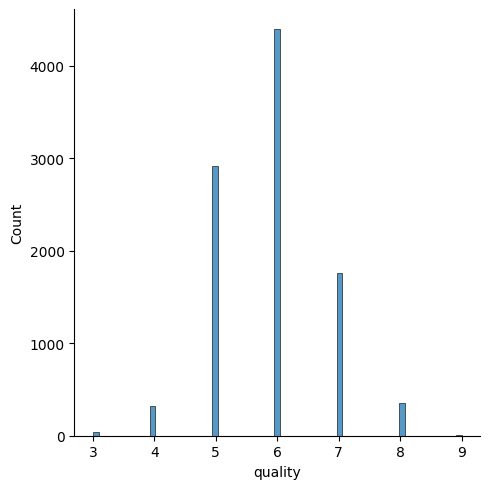

In [0]:
import seaborn as sns

sns.displot(data.quality, kde=False)

Looks like quality scores are normally distributed between 3 and 9. 

Define a wine as high quality if it has quality >= 7.

In [0]:
high_quality = (data.quality >= 7).astype(int)
data.quality = high_quality

Box plots are useful for identifying correlations between features and a binary label. Create box plots for each feature to compare high-quality and low-quality wines. Significant differences in the box plots indicate good predictors of quality.

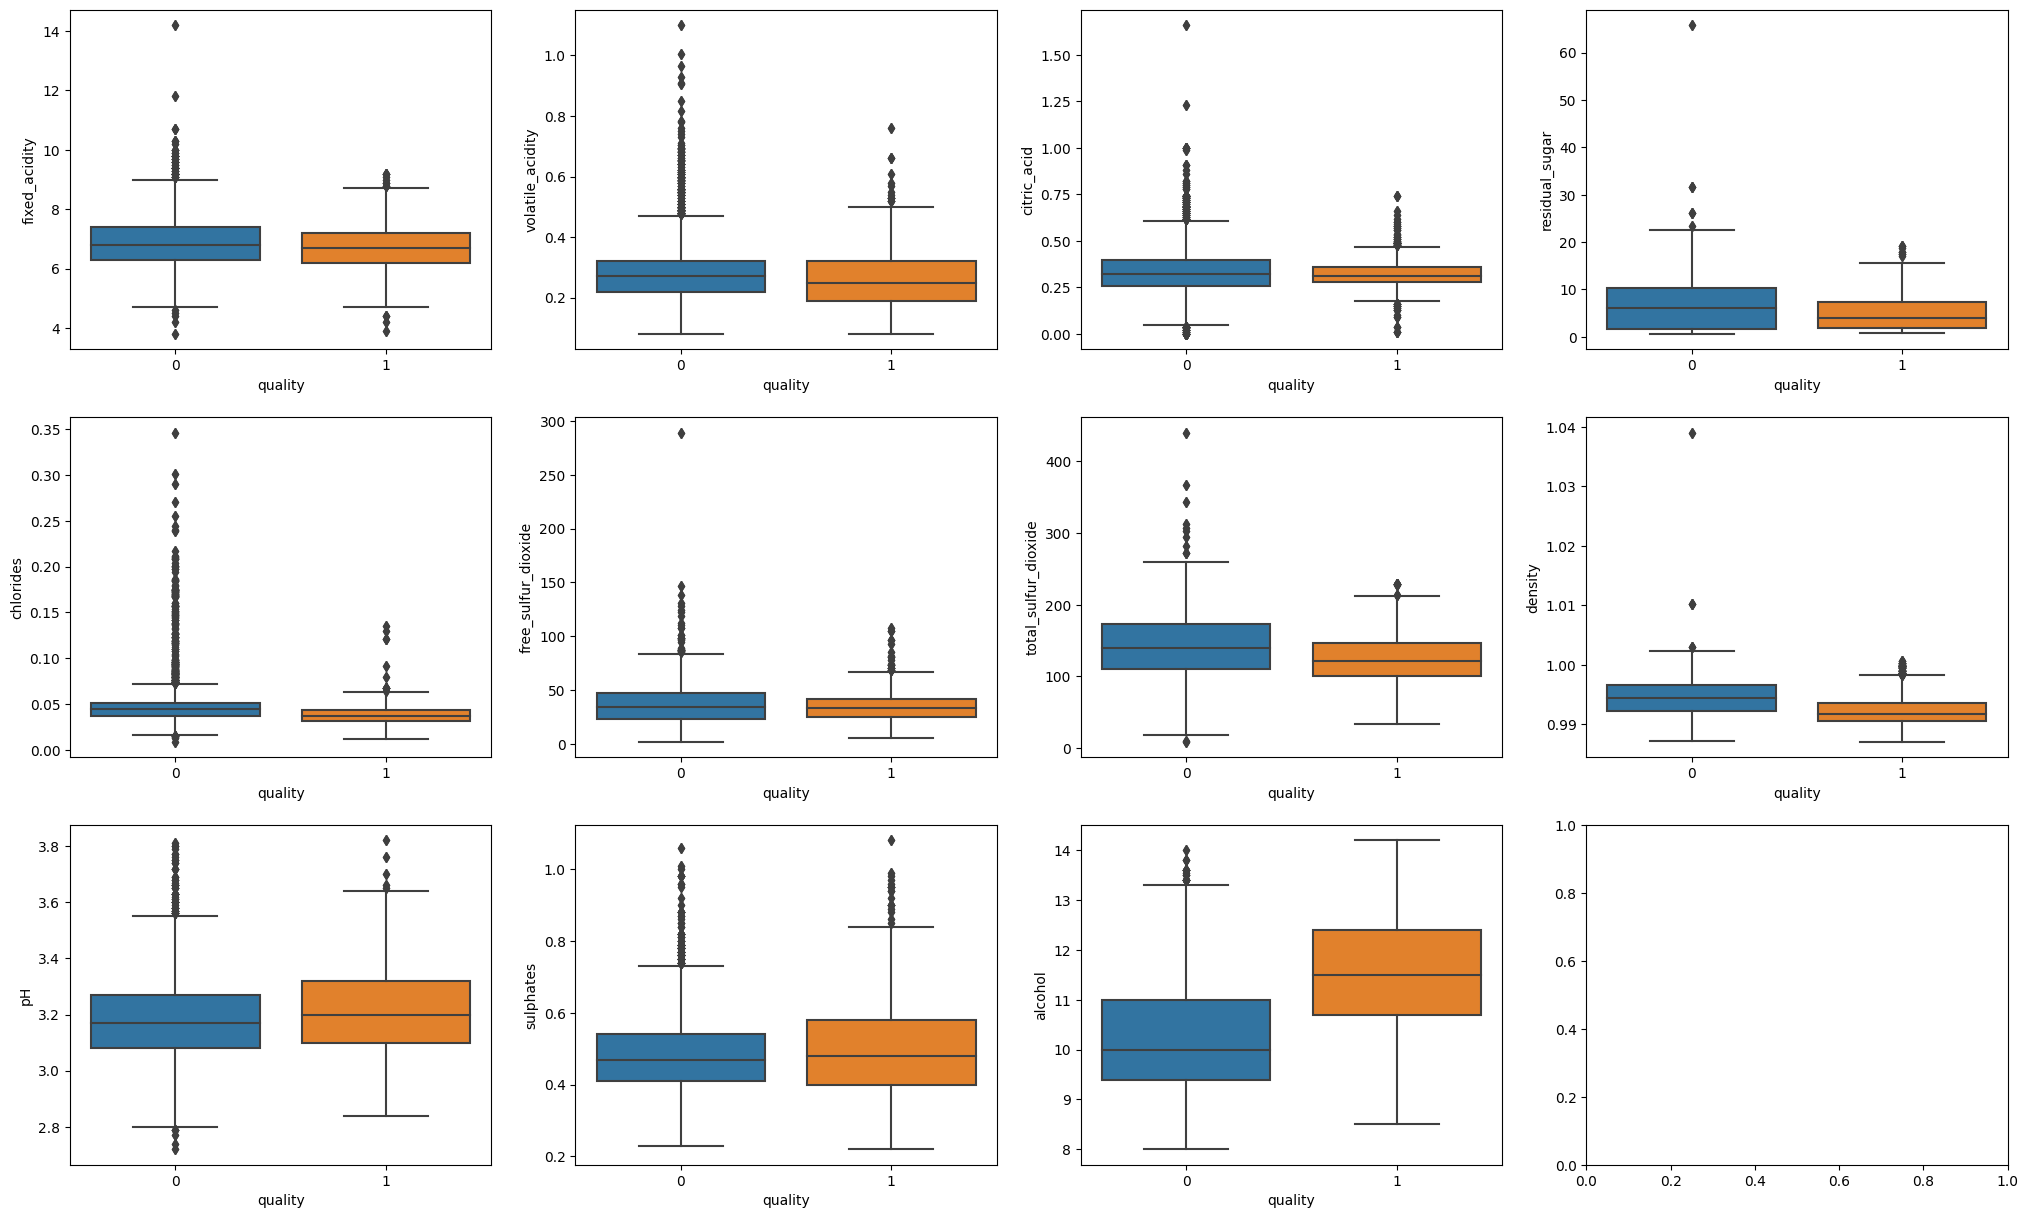

In [0]:
import matplotlib.pyplot as plt

dims = (3, 4)

f, axes = plt.subplots(dims[0], dims[1], figsize=(25, 15))
axis_i, axis_j = 0, 0
for col in data.columns:
  if col == 'is_red' or col == 'quality':
    continue # Box plots cannot be used on indicator variables
  sns.boxplot(x=high_quality, y=data[col], ax=axes[axis_i, axis_j])
  axis_j += 1
  if axis_j == dims[1]:
    axis_i += 1
    axis_j = 0

In the above box plots, a few variables stand out as good univariate predictors of quality. 

- In the alcohol box plot, the median alcohol content of high quality wines is greater than even the 75th quantile of low quality wines. High alcohol content is correlated with quality.
- In the density box plot, low quality wines have a greater density than high quality wines. Density is inversely correlated with quality.

## Preprocess data
Before training a model, check for missing values and split the data into training and validation sets.

In [0]:
data.isna().any()

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
is_red                  False
dtype: bool

There are no missing values.

## Prepare the dataset to train a baseline model
Split the input data into 3 sets:
- Train (60% of the dataset used to train the model)
- Validation (20% of the dataset used to tune the hyperparameters)
- Test (20% of the dataset used to report the true performance of the model on an unseen dataset)

In [0]:
from sklearn.model_selection import train_test_split

X = data.drop(["quality"], axis=1)
y = data.quality

# Split out the training data
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, random_state=123)

# Split the remaining data equally into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, random_state=123)

## Train a baseline model
This task seems well suited to a random forest classifier, since the output is binary and there may be interactions between multiple variables.

Build a simple classifier using scikit-learn and use MLflow to keep track of the model's accuracy, and to save the model for later use.

In [0]:
import mlflow
import mlflow.pyfunc
import mlflow.sklearn
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from mlflow.models.signature import infer_signature
from mlflow.utils.environment import _mlflow_conda_env
import cloudpickle
import time

# The predict method of sklearn's RandomForestClassifier returns a binary classification (0 or 1). 
# The following code creates a wrapper function, SklearnModelWrapper, that uses 
# the predict_proba method to return the probability that the observation belongs to each class. 

class SklearnModelWrapper(mlflow.pyfunc.PythonModel):
  def __init__(self, model):
    self.model = model
    
  def predict(self, context, model_input):
    return self.model.predict_proba(model_input)[:,1]

# mlflow.start_run creates a new MLflow run to track the performance of this model. 
# Within the context, you call mlflow.log_param to keep track of the parameters used, and
# mlflow.log_metric to record metrics like accuracy.
with mlflow.start_run(run_name='untuned_random_forest'):
  n_estimators = 10
  model = RandomForestClassifier(n_estimators=n_estimators, random_state=np.random.RandomState(123))
  model.fit(X_train, y_train)

  # predict_proba returns [prob_negative, prob_positive], so slice the output with [:, 1]
  predictions_test = model.predict_proba(X_test)[:,1]
  auc_score = roc_auc_score(y_test, predictions_test)
  mlflow.log_param('n_estimators', n_estimators)
  # Use the area under the ROC curve as a metric.
  mlflow.log_metric('auc', auc_score)
  wrappedModel = SklearnModelWrapper(model)
  # Log the model with a signature that defines the schema of the model's inputs and outputs. 
  # When the model is deployed, this signature will be used to validate inputs.
  signature = infer_signature(X_train, wrappedModel.predict(None, X_train))
  
  # MLflow contains utilities to create a conda environment used to serve models.
  # The necessary dependencies are added to a conda.yaml file which is logged along with the model.
  conda_env =  _mlflow_conda_env(
        additional_conda_deps=None,
        additional_pip_deps=["cloudpickle=={}".format(cloudpickle.__version__), "scikit-learn=={}".format(sklearn.__version__)],
        additional_conda_channels=None,
    )
  mlflow.pyfunc.log_model("random_forest_model", python_model=wrappedModel, conda_env=conda_env, signature=signature)

/databricks/python/lib/python3.11/site-packages/mlflow/types/utils.py:406: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/databricks/python/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

2024/12/02 18:16:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run untuned_random_forest at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/e0307a288fb1418c9933d8e2402ce70c.
2024/12/02 18:16:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.


Review the learned feature importances output by the model. As illustrated by the previous boxplots, alcohol and density are important in predicting quality.

In [0]:
feature_importances = pd.DataFrame(model.feature_importances_, index=X_train.columns.tolist(), columns=['importance'])
feature_importances.sort_values('importance', ascending=False)

importance
density                 0.142748
alcohol                 0.135720
residual_sugar          0.093605
volatile_acidity        0.085445
free_sulfur_dioxide     0.083719
total_sulfur_dioxide    0.081837
pH                      0.081770
chlorides               0.080569
fixed_acidity           0.075831
sulphates               0.069034
citric_acid             0.066130
is_red                  0.003591

You logged the Area Under the ROC Curve (AUC) to MLflow. Click the Experiment icon <img src="https://docs.databricks.com/_static/images/icons/experiment.png"/> in the right sidebar to display the Experiment Runs sidebar. 

The model achieved an AUC of 0.854.

A random classifier would have an AUC of 0.5, and higher AUC values are better. For more information, see [Receiver Operating Characteristic Curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

#### Register the model in MLflow Model Registry

By registering this model in Model Registry, you can easily reference the model from anywhere within Databricks.

The following section shows how to do this programmatically.

In [0]:
run_id = mlflow.search_runs(filter_string='tags.mlflow.runName = "untuned_random_forest"').iloc[0].run_id

In [0]:
# If you see the error "PERMISSION_DENIED: User does not have any permission level assigned to the registered model", 
# the cause may be that a model already exists with the name "wine_quality". Try using a different name.
model_name = "wine_quality"
model_version = mlflow.register_model(f"runs:/{run_id}/random_forest_model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

You should now see the model in the Models page. To display the Models page, click **Models** in the left sidebar. 

Next, transition this model to production and load it into this notebook from Model Registry.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Production",
)

The Models page now shows the model version in stage "Production".

You can now refer to the model using the path "models:/wine_quality/production".

In [0]:
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")

# Sanity-check: This should match the AUC logged by MLflow
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

##Experiment with a new model

The random forest model performed well even without hyperparameter tuning.

Use the xgboost library to train a more accurate model. Run a hyperparameter sweep to train multiple models in parallel, using Hyperopt and SparkTrials. As before, MLflow tracks the performance of each parameter configuration.

In [0]:
from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
import mlflow.xgboost
import numpy as np
import xgboost as xgb

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
  'learning_rate': hp.loguniform('learning_rate', -3, 0),
  'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
  'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'objective': 'binary:logistic',
  'seed': 123, # Set a seed for deterministic training
}

def train_model(params):
  # With MLflow autologging, hyperparameters and the trained model are automatically logged to MLflow.
  mlflow.xgboost.autolog()
  with mlflow.start_run(nested=True):
    train = xgb.DMatrix(data=X_train, label=y_train)
    validation = xgb.DMatrix(data=X_val, label=y_val)
    # Pass in the validation set so xgb can track an evaluation metric. XGBoost terminates training when the evaluation metric
    # is no longer improving.
    booster = xgb.train(params=params, dtrain=train, num_boost_round=1000,\
                        evals=[(validation, "validation")], early_stopping_rounds=50)
    validation_predictions = booster.predict(validation)
    auc_score = roc_auc_score(y_val, validation_predictions)
    mlflow.log_metric('auc', auc_score)

    signature = infer_signature(X_train, booster.predict(train))
    mlflow.xgboost.log_model(booster, "model", signature=signature)
    
    # Set the loss to -1*auc_score so fmin maximizes the auc_score
    return {'status': STATUS_OK, 'loss': -1*auc_score, 'booster': booster.attributes()}

# Greater parallelism will lead to speedups, but a less optimal hyperparameter sweep. 
# A reasonable value for parallelism is the square root of max_evals.
spark_trials = SparkTrials(parallelism=10)

# Run fmin within an MLflow run context so that each hyperparameter configuration is logged as a child run of a parent
# run called "xgboost_models" .
with mlflow.start_run(run_name='xgboost_models'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=96,
    trials=spark_trials,
  )

Hyperopt with SparkTrials will automatically track trials in MLflow. To view the MLflow experiment associated with the notebook, click the 'Runs' icon in the notebook context bar on the upper right. There, you can view all runs.
To view logs from trials, please check the Spark executor logs. To view executor logs, expand 'Spark Jobs' above until you see the (i) icon next to the stage from the trial job. Click it and find the list of tasks. Click the 'stderr' link for a task to view trial logs.


  3%|▎         | 3/96 [01:09<36:00, 23.23s/trial, best loss: -0.9769830941109161]

2024/12/02 18:26:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run painted-asp-909 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/593f091de1f3446ea328b3782d6d68d8.

2024/12/02 18:26:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:26:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-doe-282 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/abf42f09342f41398edee2654d9fcee8.

2024/12/02 18:26:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:26:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run indecisive-ant-765 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/b905aa8175b544a7b4ee20d1bc32724d.

2024/12/02 18:26:31 INFO mlflow.tracking._trac

  4%|▍         | 4/96 [01:12<25:37, 16.72s/trial, best loss: -0.9769830941109161]

2024/12/02 18:26:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-finch-40 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/66ced4de486542e2970333ef6de0ea58.

2024/12/02 18:26:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



  6%|▋         | 6/96 [01:17<13:27,  8.98s/trial, best loss: -0.9779685898765851]

2024/12/02 18:26:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-hound-7 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/1b65fb2ea33c4530bff1f5c2ae7ff9f7.

2024/12/02 18:26:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:26:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run sedate-horse-302 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/0fdfa86aa5394de2ae775f53d622e051.

2024/12/02 18:26:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



  7%|▋         | 7/96 [01:26<13:20,  8.99s/trial, best loss: -0.9779685898765851]

2024/12/02 18:26:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-kite-48 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3a6e612e7a4d4000bba54c9514bc13f5.

2024/12/02 18:26:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



  8%|▊         | 8/96 [01:30<10:57,  7.47s/trial, best loss: -0.9779685898765851]

2024/12/02 18:26:52 INFO mlflow.tracking._tracking_service.client: 🏃 View run mysterious-sow-330 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/5f26ab0fffb14f08b3c50ad95da2a233.

2024/12/02 18:26:52 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



  9%|▉         | 9/96 [02:15<27:21, 18.87s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-shoat-859 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/d3dd84a68f26434eab1ad1f8d7216739.

2024/12/02 18:27:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 10%|█         | 10/96 [02:19<20:36, 14.38s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run worried-goose-648 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3aecdf0ca9c54afe8c49ce777a094ef7.

2024/12/02 18:27:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 11%|█▏        | 11/96 [02:21<15:05, 10.66s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-deer-904 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/7a4f3dcfe8164a23991a5dbb8e0fe334.

2024/12/02 18:27:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 12%|█▎        | 12/96 [02:23<11:23,  8.13s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-koi-728 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3ad602dec71048b781d7b04d750d5373.

2024/12/02 18:27:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 14%|█▎        | 13/96 [02:27<09:34,  6.92s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run funny-lark-496 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/393a67092c394e3aa9372a59ab74f789.

2024/12/02 18:27:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 15%|█▍        | 14/96 [02:33<09:06,  6.66s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-vole-279 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/40cac0fc8f3f4ddfa8c7bc7504294e9a.

2024/12/02 18:27:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 17%|█▋        | 16/96 [02:37<05:44,  4.31s/trial, best loss: -0.9779685898765851]

2024/12/02 18:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-turtle-147 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/b66c4fcd9d4d4f6bacd435e3f96a9ca0.

2024/12/02 18:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:27:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run awesome-flea-251 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/cab31f888c8f44c2ab111e4dc44023ce.

2024/12/02 18:27:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 18%|█▊        | 17/96 [03:23<22:10, 16.84s/trial, best loss: -0.9779685898765851]

2024/12/02 18:28:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-grub-569 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/d8b72483b37040f7bfd5b7ace8ba96ba.

2024/12/02 18:28:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 19%|█▉        | 18/96 [03:29<17:42, 13.62s/trial, best loss: -0.9779685898765851]

2024/12/02 18:28:51 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-stag-829 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a62cac92877e463d94fe2bb5b7a41609.

2024/12/02 18:28:51 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 21%|██        | 20/96 [03:33<09:40,  7.64s/trial, best loss: -0.9779685898765851]

2024/12/02 18:28:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-ape-43 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/7290bc13370d491fba7921e6e3d907d6.

2024/12/02 18:28:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:28:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run burly-vole-567 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/ea75f73e335f437f90221376ec01bd11.

2024/12/02 18:28:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 22%|██▏       | 21/96 [03:37<08:06,  6.48s/trial, best loss: -0.978861351590939] 

2024/12/02 18:28:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run carefree-crab-509 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/4cfb8b0cb14d472b9ff889f0b22bfcba.

2024/12/02 18:28:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 23%|██▎       | 22/96 [03:41<07:06,  5.76s/trial, best loss: -0.978861351590939]

2024/12/02 18:29:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-wren-945 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/b655d8cd03984bf5b7f30eca586daab9.

2024/12/02 18:29:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 25%|██▌       | 24/96 [03:47<05:02,  4.21s/trial, best loss: -0.978861351590939]

2024/12/02 18:29:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run defiant-ray-427 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/e5f7b6d364d04a2797d4ded7d6df53bd.

2024/12/02 18:29:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:29:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run shivering-flea-285 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a985562f7f48461fa8a6b64bf6090238.

2024/12/02 18:29:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 26%|██▌       | 25/96 [04:32<19:14, 16.26s/trial, best loss: -0.978861351590939]

2024/12/02 18:29:53 INFO mlflow.tracking._tracking_service.client: 🏃 View run skillful-stork-148 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a23771b3cd5043ed9b850a03e6a1e4d0.

2024/12/02 18:29:53 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 27%|██▋       | 26/96 [04:38<15:23, 13.20s/trial, best loss: -0.978861351590939]

2024/12/02 18:30:01 INFO mlflow.tracking._tracking_service.client: 🏃 View run enthused-shrike-369 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/bf6ea73331244c938e84ca937b82acde.

2024/12/02 18:30:01 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 28%|██▊       | 27/96 [04:40<11:19,  9.85s/trial, best loss: -0.978861351590939]

2024/12/02 18:30:03 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-steed-583 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/64a911f82f5f48d18318b6666d474652.

2024/12/02 18:30:03 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 29%|██▉       | 28/96 [04:42<08:31,  7.52s/trial, best loss: -0.978861351590939]

2024/12/02 18:30:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-shoat-70 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a7f72ae3eed34c328358d0380d1ad397.

2024/12/02 18:30:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 30%|███       | 29/96 [04:48<07:58,  7.15s/trial, best loss: -0.978861351590939]

2024/12/02 18:30:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-lamb-592 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/b8fa8363ea9d4708a1ff0580c3d045c9.

2024/12/02 18:30:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 33%|███▎      | 32/96 [04:57<04:50,  4.55s/trial, best loss: -0.978861351590939]

2024/12/02 18:30:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run dapper-moose-227 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/726dee6d0d3e4b9c802564502e0cc924.

2024/12/02 18:30:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:30:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run judicious-dove-218 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/ce23e236e8584d20869854bd16bce20d.

2024/12/02 18:30:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:30:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-quail-311 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/f44bea2133df484c9dae1bb09abbc367.

2024/12/02 18:30:20 INFO mlflow.tracking._

 34%|███▍      | 33/96 [05:45<16:30, 15.72s/trial, best loss: -0.978861351590939]

2024/12/02 18:31:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-wren-685 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/016521a120154b0a85499f14622eca35.

2024/12/02 18:31:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 36%|███▋      | 35/96 [05:54<10:17, 10.12s/trial, best loss: -0.978861351590939]

2024/12/02 18:31:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-deer-862 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/c264846f1257449b87763060d4ba4b6c.

2024/12/02 18:31:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:31:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run suave-sponge-284 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/18b7313ed8994cada7c24c8763602a44.

2024/12/02 18:31:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 38%|███▊      | 36/96 [05:57<08:06,  8.11s/trial, best loss: -0.978861351590939]

2024/12/02 18:31:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-koi-43 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/743e86998e714e46a9c331bc8fca9225.

2024/12/02 18:31:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 39%|███▊      | 37/96 [06:01<06:50,  6.95s/trial, best loss: -0.978861351590939]

2024/12/02 18:31:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run secretive-loon-511 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/39214cf57f434f05abbfe3877b046691.

2024/12/02 18:31:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 41%|████      | 39/96 [06:08<05:03,  5.33s/trial, best loss: -0.9790593938022218]

2024/12/02 18:31:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run exultant-shad-526 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/93cd85e6aafd4e0fa63a8ae19ef62574.

2024/12/02 18:31:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:31:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run redolent-deer-800 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/c94344ba9dc84502b0237e91eb300cd9.

2024/12/02 18:31:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 42%|████▏     | 40/96 [06:13<04:56,  5.30s/trial, best loss: -0.9790593938022218]

2024/12/02 18:31:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run colorful-lamb-596 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/92f282a357b248a9bd74ec2ce4bd0531.

2024/12/02 18:31:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 43%|████▎     | 41/96 [06:59<14:29, 15.81s/trial, best loss: -0.9790672526201301]

2024/12/02 18:32:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-skunk-395 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a0a2b7b745b5402e8668a688cfc5504e.

2024/12/02 18:32:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 44%|████▍     | 42/96 [07:05<11:59, 13.32s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:27 INFO mlflow.tracking._tracking_service.client: 🏃 View run magnificent-swan-944 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/76436375f30d469bb1925aba8f077178.

2024/12/02 18:32:27 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 45%|████▍     | 43/96 [07:08<09:00, 10.20s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run bright-penguin-70 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/42fd42aea4aa48178ebbdd316db96237.

2024/12/02 18:32:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 47%|████▋     | 45/96 [07:11<05:25,  6.38s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run serious-robin-333 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/2ac2830c5d664da3842a27bc946dfc90.

2024/12/02 18:32:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:32:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-swan-534 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/0b1f5675b9d94b3f94669bf8764425fc.

2024/12/02 18:32:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 48%|████▊     | 46/96 [07:17<05:16,  6.33s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-sloth-676 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/4f38950257444cf5b3d151d28a983ecd.

2024/12/02 18:32:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 49%|████▉     | 47/96 [07:23<05:06,  6.26s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run persistent-wasp-245 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/c06d28896626427b9e4b7b55ab2b834d.

2024/12/02 18:32:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 50%|█████     | 48/96 [07:26<04:19,  5.40s/trial, best loss: -0.9791442690356287]

2024/12/02 18:32:48 INFO mlflow.tracking._tracking_service.client: 🏃 View run placid-bee-237 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/4e3070d23bf44d68956ea21a356ab339.

2024/12/02 18:32:48 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 51%|█████     | 49/96 [08:08<12:12, 15.59s/trial, best loss: -0.9791442690356287]

2024/12/02 18:33:31 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-panda-268 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/2b333964890949d785ae01c35ad740c6.

2024/12/02 18:33:31 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 53%|█████▎    | 51/96 [08:16<07:15,  9.67s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-quail-529 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/ad81de512564457aaf8de97152420da5.

2024/12/02 18:33:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 54%|█████▍    | 52/96 [08:17<05:14,  7.14s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-sow-103 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/263aaea8c6904cf880eb25fef7a9d179.

2024/12/02 18:33:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:33:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run tasteful-rat-881 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/566304c885b34306ae2c134300cabdd0.

2024/12/02 18:33:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 55%|█████▌    | 53/96 [08:21<04:30,  6.28s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run salty-frog-154 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/92711848537e47bb8455e0dc4a5a5705.

2024/12/02 18:33:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 56%|█████▋    | 54/96 [08:26<03:56,  5.62s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run masked-conch-741 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/0bd7bfc73f8a480e83473280c75bccee.

2024/12/02 18:33:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 57%|█████▋    | 55/96 [08:32<03:56,  5.77s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-deer-298 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/cd43b93a341c4c89bcee51720dc82a6d.

2024/12/02 18:33:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 58%|█████▊    | 56/96 [08:33<02:55,  4.38s/trial, best loss: -0.9796252286916012]

2024/12/02 18:33:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run debonair-foal-386 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/082e5039533345f8b438eb6507b310e7.

2024/12/02 18:33:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 59%|█████▉    | 57/96 [09:18<10:44, 16.54s/trial, best loss: -0.9796252286916012]

2024/12/02 18:34:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-mink-839 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/769ad403de664102adb8c863477bfa94.

2024/12/02 18:34:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 61%|██████▏   | 59/96 [09:21<05:56,  9.63s/trial, best loss: -0.9796252286916012]

2024/12/02 18:34:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-seal-734 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/d7821de9fe7b4f239b3ae8f53d6e69cb.

2024/12/02 18:34:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:34:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run nosy-skink-32 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3626af9104cb489a928675c0bfac7a0d.

2024/12/02 18:34:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 64%|██████▎   | 61/96 [09:27<04:06,  7.04s/trial, best loss: -0.9796252286916012]

2024/12/02 18:34:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run unique-grouse-605 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a22981ce3dc24a4cb5c9c7b7be7872da.

2024/12/02 18:34:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:34:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-shark-867 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/95199b3c34e14bf39833d302d8d3eece.

2024/12/02 18:34:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 65%|██████▍   | 62/96 [09:31<03:38,  6.41s/trial, best loss: -0.9796252286916012]

2024/12/02 18:34:54 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-finch-970 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/380984d1840e4f17bb139beab3ab7d24.

2024/12/02 18:34:54 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 66%|██████▌   | 63/96 [09:37<03:29,  6.33s/trial, best loss: -0.9796252286916012]

2024/12/02 18:35:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run adorable-owl-326 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/91a3a22ca5114d198ce7f104ca12bc07.

2024/12/02 18:35:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 67%|██████▋   | 64/96 [09:40<02:48,  5.26s/trial, best loss: -0.9796252286916012]

2024/12/02 18:35:02 INFO mlflow.tracking._tracking_service.client: 🏃 View run legendary-sheep-601 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/8053d3f050434208b6e97e37954b9d7a.

2024/12/02 18:35:02 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 69%|██████▉   | 66/96 [10:28<06:05, 12.19s/trial, best loss: -0.9796252286916012]

2024/12/02 18:35:49 INFO mlflow.tracking._tracking_service.client: 🏃 View run respected-auk-310 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/668b00077f864479aa411d8a21780fab.

2024/12/02 18:35:49 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:35:50 INFO mlflow.tracking._tracking_service.client: 🏃 View run abundant-cub-950 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/c8d1f55a661144af86f3aa5e3bd41801.

2024/12/02 18:35:50 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 70%|██████▉   | 67/96 [10:33<04:56, 10.22s/trial, best loss: -0.9796252286916012]

2024/12/02 18:35:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run mercurial-shrike-739 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/4ef9c9a970a948ffb8354e95284585dd.

2024/12/02 18:35:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 72%|███████▏  | 69/96 [10:35<02:46,  6.16s/trial, best loss: -0.9796252286916012]

2024/12/02 18:35:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run enchanting-croc-20 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/8aa94babdcaa46df96b3f1f1797e9a0f.

2024/12/02 18:35:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:35:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run handsome-flea-588 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/95af9539122e496abd33baedd97bc98c.

2024/12/02 18:35:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 73%|███████▎  | 70/96 [10:42<02:46,  6.41s/trial, best loss: -0.9796252286916012]

2024/12/02 18:36:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run gifted-sponge-443 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/9a21034ccbd44521823cf816bf743279.

2024/12/02 18:36:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 74%|███████▍  | 71/96 [10:48<02:38,  6.33s/trial, best loss: -0.9796252286916012]

2024/12/02 18:36:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-kite-767 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/f778d2b7ca0f49a5919de6ee084b1997.

2024/12/02 18:36:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 75%|███████▌  | 72/96 [10:50<01:59,  4.99s/trial, best loss: -0.9796252286916012]

2024/12/02 18:36:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-hare-903 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/32f11970cf58433d9bcb152f30dfcf44.

2024/12/02 18:36:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 76%|███████▌  | 73/96 [11:33<05:58, 15.57s/trial, best loss: -0.9796252286916012]

2024/12/02 18:36:56 INFO mlflow.tracking._tracking_service.client: 🏃 View run rumbling-bird-296 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/a353c3dd81d44c74a7c6b5484987dd05.

2024/12/02 18:36:56 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 77%|███████▋  | 74/96 [11:36<04:24, 12.03s/trial, best loss: -0.9796252286916012]

2024/12/02 18:36:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run rambunctious-roo-800 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/86adf851b3e541d49e3fea584f22412b.

2024/12/02 18:36:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 78%|███████▊  | 75/96 [11:41<03:30, 10.03s/trial, best loss: -0.9796252286916012]

2024/12/02 18:37:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-moose-57 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/aaa49cb06fed490591c32706e4f81f4e.

2024/12/02 18:37:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 79%|███████▉  | 76/96 [11:43<02:35,  7.76s/trial, best loss: -0.9796252286916012]

2024/12/02 18:37:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run treasured-stork-617 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3fd2aad318d7463d98bc6d4f015d3b76.

2024/12/02 18:37:06 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 80%|████████  | 77/96 [11:48<02:07,  6.69s/trial, best loss: -0.9796252286916012]

2024/12/02 18:37:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run amazing-hare-697 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/6d5789757f7d4f358cad0f7ed321072e.

2024/12/02 18:37:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 81%|████████▏ | 78/96 [11:53<01:51,  6.22s/trial, best loss: -0.9796252286916012]

2024/12/02 18:37:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-auk-435 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/bbd4275605b8400e808f78050b82b5fe.

2024/12/02 18:37:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 83%|████████▎ | 80/96 [12:01<01:23,  5.23s/trial, best loss: -0.9796252286916012]

2024/12/02 18:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run grandiose-chimp-137 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/8e2c2862e3904c0fbb74b61046f44376.

2024/12/02 18:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:37:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-robin-318 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/9983d1a6d9f74dd2ba5e7dd3c86dffe0.

2024/12/02 18:37:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 84%|████████▍ | 81/96 [12:42<03:31, 14.13s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:04 INFO mlflow.tracking._tracking_service.client: 🏃 View run nosy-moth-188 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/de88ca3077114f9bb3b2d88c2f6d8977.

2024/12/02 18:38:04 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 85%|████████▌ | 82/96 [12:45<02:37, 11.26s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-snake-194 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/db97fcc436054cdbae9d19abbe38a7ba.

2024/12/02 18:38:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 88%|████████▊ | 84/96 [12:51<01:24,  7.06s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-dolphin-5 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/4fa35bc5cb3d45729505f37954b190ec.

2024/12/02 18:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:38:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run righteous-boar-331 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/cc65c9f92e594a81a36e7c1f52283f5e.

2024/12/02 18:38:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 89%|████████▊ | 85/96 [12:54<01:05,  5.94s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-wren-614 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/f9bc832e07e74665b238cf89c13b48aa.

2024/12/02 18:38:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 90%|████████▉ | 86/96 [13:01<01:02,  6.26s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run thoughtful-ox-111 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/b0ea0e2377464fe1937dd7e11f920828.

2024/12/02 18:38:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 91%|█████████ | 87/96 [13:07<00:55,  6.19s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:29 INFO mlflow.tracking._tracking_service.client: 🏃 View run youthful-ox-313 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/c03062f85a364f30a6bf44d5bc528e68.

2024/12/02 18:38:29 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 92%|█████████▏| 88/96 [13:10<00:41,  5.25s/trial, best loss: -0.9796252286916012]

2024/12/02 18:38:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run intelligent-jay-773 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/78f0449647d94e77a00be5f9d05dd917.

2024/12/02 18:38:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 93%|█████████▎| 89/96 [13:50<01:48, 15.55s/trial, best loss: -0.9796252286916012]

2024/12/02 18:39:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run dashing-asp-917 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/ebf11a9922e741ccb9c6d2867c849183.

2024/12/02 18:39:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 95%|█████████▍| 91/96 [13:54<00:46,  9.34s/trial, best loss: -0.9796252286916012]

2024/12/02 18:39:15 INFO mlflow.tracking._tracking_service.client: 🏃 View run crawling-duck-174 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/3c9bb3a832fc4de497126e42f81626ff.

2024/12/02 18:39:15 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:39:16 INFO mlflow.tracking._tracking_service.client: 🏃 View run skittish-calf-569 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/9af3a47f10bf423f99cdba3d1e20eee6.

2024/12/02 18:39:16 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 97%|█████████▋| 93/96 [13:57<00:18,  6.24s/trial, best loss: -0.9796252286916012]

2024/12/02 18:39:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run fun-hound-206 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/9fc015eb812b47fca578be94af073ad3.

2024/12/02 18:39:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:39:18 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-toad-147 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/87ac51bdc4f847ebaf4aa1a129b94120.

2024/12/02 18:39:18 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



 98%|█████████▊| 94/96 [14:01<00:11,  5.75s/trial, best loss: -0.9796252286916012]

2024/12/02 18:39:22 INFO mlflow.tracking._tracking_service.client: 🏃 View run amusing-stork-800 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/f899fd3188b54c979e5f53eae23ebd94.

2024/12/02 18:39:22 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.

2024/12/02 18:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run sincere-horse-675 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/7ab3a5fb91ed47e0b2c1daeecd14c089.

2024/12/02 18:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.



100%|██████████| 96/96 [14:03<00:00,  8.78s/trial, best loss: -0.9796252286916012]


2024/12/02 18:39:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-shoat-531 at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/31ffb669cfe542b1965b5b038b8c7dc4.
2024/12/02 18:39:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.
Total Trials: 96: 96 succeeded, 0 failed, 0 cancelled.
2024/12/02 18:39:25 INFO mlflow.tracking._tracking_service.client: 🏃 View run xgboost_models at: https://community.cloud.databricks.com/ml/experiments/2257920193812608/runs/580a8f8a8ff04415bb5645fb5eb68679.
2024/12/02 18:39:25 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://community.cloud.databricks.com/ml/experiments/2257920193812608.


#### Use MLflow to view the results
Open up the Experiment Runs sidebar to see the MLflow runs. Click on Date next to the down arrow to display a menu, and select 'auc' to display the runs sorted by the auc metric. The highest auc value is 0.90.

MLflow tracks the parameters and performance metrics of each run. Click the External Link icon <img src="https://docs.databricks.com/_static/images/icons/external-link.png"/> at the top of the Experiment Runs sidebar to navigate to the MLflow Runs Table. 

For details about how to use the MLflow runs table to understand how the effect of individual hyperparameters on run metrics, see the  documentation ([AWS](https://docs.databricks.com/mlflow/runs.html#compare-runs) | [Azure](https://docs.microsoft.com/azure/databricks//mlflow/runs#--compare-runs) | [GCP](https://docs.gcp.databricks.com/mlflow/runs.html#compare-runs)). 



#### Update the production `wine_quality` model in MLflow Model Registry
Earlier, you saved the baseline model to Model Registry with the name `wine_quality`. Now you can update `wine_quality` to a more accurate model from the hyperparameter sweep.

Because you used MLflow to log the model produced by each hyperparameter configuration, you can use MLflow to identify the best performing run and save the model from that run to the Model Registry.

In [0]:
best_run = mlflow.search_runs(order_by=['metrics.auc DESC']).iloc[0]
print(f'AUC of Best Run: {best_run["metrics.auc"]}')

AUC of Best Run: 0.9796252286916012


In [0]:
new_model_version = mlflow.register_model(f"runs:/{best_run.run_id}/model", model_name)

# Registering the model takes a few seconds, so add a small delay
time.sleep(15)

Click **Models** in the left sidebar to see that the `wine_quality` model now has two versions. 

Promote the new version to production.

In [0]:
# Archive the old model version
client.transition_model_version_stage(
  name=model_name,
  version=model_version.version,
  stage="Archived"
)

# Promote the new model version to Production
client.transition_model_version_stage(
  name=model_name,
  version=new_model_version.version,
  stage="Production"
)

Clients that call load_model now receive the new model.

In [0]:
# This code is the same as the last block of "Building a Baseline Model". No change is required for clients to get the new model!
model = mlflow.pyfunc.load_model(f"models:/{model_name}/production")
print(f'AUC: {roc_auc_score(y_test, model.predict(X_test))}')

The new version achieved a better score (AUC = 0.90) on the test set.

##Batch inference

There are many scenarios where you might want to evaluate a model on a corpus of new data. For example, you may have a fresh batch of data, or may need to compare the performance of two models on the same corpus of data.

Evaluate the model on data stored in a Delta table, using Spark to run the computation in parallel.

In [0]:
# To simulate a new corpus of data, save the existing X_train data to a Delta table. 
# In the real world, this would be a new batch of data.
spark_df = spark.createDataFrame(X_train)
# Replace <username> with your username before running this cell.
table_path = "dbfs:/<username>/delta/wine_data"
# Delete the contents of this path in case this cell has already been run
dbutils.fs.rm(table_path, True)
spark_df.write.format("delta").save(table_path)

Load the model into a Spark UDF, so it can be applied to the Delta table.

In [0]:
import mlflow.pyfunc

apply_model_udf = mlflow.pyfunc.spark_udf(spark, f"models:/{model_name}/production")

In [0]:
# Read the "new data" from Delta
new_data = spark.read.format("delta").load(table_path)

In [0]:
display(new_data)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol is_red 6.9 0.38 0.29 13.65 0.048 52.0 189.0 0.99784 3.0 0.6 9.5 1 7.7 0.3 0.26 18.95 0.053 36.0 174.0 0.99976 3.2 0.5 10.4 0 8.3 0.4 0.41 8.2 0.05 15.0 122.0 0.9979 3.39 0.49 9.3 0 8.4 0.22 0.3 1.3 0.038 45.0 122.0 0.99178 3.13 0.54 10.8 0 7.0 0.22 0.24 11.0 0.041 75.0 167.0 0.99508 2.98 0.56 10.5 1 7.9 0.18 0.37 3.0 0.061 25.0 178.0 0.995 3.22 0.51 10.0 0 6.1 0.18 0.38 2.3 0.033 28.0 111.0 0.98962 3.16 0.49 12.4 0 6.2 0.3 0.32 1.2 0.052 32.0 185.0 0.99266 3.28 0.44 10.1 1 6.5 0.37 0.3 2.2 0.033 39.0 107.0 0.98894 3.22 0.53 13.5 0 6.2 0.36 0.45 10.4 0.06 22.0 184.0 0.99711 3.31 0.56 9.8 0 7.0 0.3 0.49 4.7 0.036 17.0 105.0 0.9916 3.26 0.68 12.4 0 8.9 0.34 0.32 1.3 0.041 12.0 188.0 0.9953 3.17 0.49 9.5 0 7.1 0.29 0.28 9.3 0.048 50.0 141.0 0.9949 3.13 0.49 10.3 0 7.2 0.24 0.27 11.4 0.034 40.0 174.0 0.99773 3.2 0.44 9.0 1 6.3 0.32 0.26 12.0 0.049 63.0 170.0 0.9961 3.14 0.55 9.9 0 6.9 0.31 0.34 1.6 0.032 23.0 128.0 0.9917 3.37 0.47 11.7 1 6.3 0.55 0.45 13.0 0.047 33.0 182.0 0.9974 3.2 0.46 9.2 1 7.1 0.23 0.23 3.5 0.038 23.0 112.0 0.99157 3.05 0.37 11.3666666666667 1 7.0 0.23 0.36 7.1 0.028 31.0 104.0 0.9922 3.35 0.47 12.1 1 8.4 0.35 0.71 12.2 0.046 22.0 160.0 0.9982 2.98 0.65 9.4 1 6.0 0.26 0.32 3.5 0.028 29.0 113.0 0.9912 3.4 0.71 12.3 1 6.7 0.18 0.25 14.3 0.048 79.0 149.0 0.9975 3.12 0.37 9.7 0 6.4 0.32 0.25 5.0 0.055 28.0 138.0 0.99171 3.27 0.5 12.4 1 6.3 0.23 0.3 1.8 0.033 16.0 91.0 0.9906 3.28 0.4 11.8 1 5.1 0.3 0.3 2.3 0.048 40.0 150.0 0.98944 3.29 0.46 12.2 1 7.6 0.28 0.49 20.15 0.06 30.0 145.0 1.00196 3.01 0.44 8.5 0 9.4 0.23 0.56 16.45 0.063 52.5 282.0 1.00098 3.1 0.51 9.3 0 7.0 0.29 0.49 3.8 0.047 37.0 136.0 0.9938 2.95 0.4 9.4 0 7.8 0.21 0.39 1.8 0.034 62.0 180.0 0.991 3.09 0.75 12.6 0 9.6 0.23 0.4 1.5 0.044 19.0 135.0 0.9937 2.96 0.49 10.9 0 7.1 0.22 0.74 2.7 0.044 42.0 144.0 0.991 3.31 0.41 12.2 1 6.9 0.18 0.36 1.3 0.036 40.0 117.0 0.9934 3.27 0.95 9.5 1 5.1 0.25 0.36 1.3 0.035 40.0 78.0 0.9891 3.23 0.64 12.1 1 6.6 0.2 0.27 10.9 0.038 29.0 130.0 0.99496 3.11 0.44 10.5 1 7.6 0.33 0.41 13.7 0.045 44.0 197.0 0.9989 3.18 0.64 9.1 0 7.8 0.49 0.49 7.0 0.043 29.0 149.0 0.9952 3.21 0.33 10.0 1 8.0 0.18 0.37 1.3 0.04 15.0 96.0 0.9912 3.06 0.61 12.1 0 6.3 0.35 0.3 5.7 0.035 8.0 97.0 0.9927 3.27 0.41 11.0 0 6.6 0.26 0.36 1.2 0.035 43.0 126.0 0.99094 3.01 0.63 11.4 0 7.0 0.15 0.28 14.7 0.051 29.0 149.0 0.99792 2.96 0.39 9.0 1 6.4 0.31 0.27 7.4 0.049 48.0 169.0 0.99323 3.27 0.45 11.1 1 6.8 0.31 0.09 1.4 0.04 56.0 145.0 0.9922 3.19 0.46 10.0 0 9.8 0.93 0.45 8.6 0.052 34.0 187.0 0.9994 3.12 0.59 10.2 0 7.5 0.28 0.34 4.2 0.028 36.0 116.0 0.991 2.99 0.41 12.3 1 7.3 0.21 0.21 1.6 0.046 35.0 133.0 0.99466 3.38 0.46 10.0 0 6.4 0.23 0.37 7.9 0.05 60.0 150.0 0.99488 2.86 0.49 9.3 1 6.3 0.32 0.32 1.5 0.037 12.0 76.0 0.98993 3.3 0.46 12.3 0 7.2 0.34 0.44 4.2 0.047 51.0 144.0 0.991 3.01 0.76 12.3 0 6.5 0.15 0.32 1.3 0.036 19.0 76.0 0.98964 3.18 0.41 12.3 0 7.4 0.2 0.36 1.2 0.038 44.0 111.0 0.9926 3.36 0.34 9.9 0 6.1 0.28 0.27 4.7 0.03 56.0 140.0 0.99042 3.16 0.42 12.5 0 5.0 0.3 0.33 3.7 0.03 54.0 173.0 0.9887 3.36 0.3 13.0 0 6.5 0.14 0.33 7.6 0.05 53.0 189.0 0.9966 3.25 0.49 8.6 1 6.8 0.475 0.33 3.95 0.047 16.0 81.0 0.98988 3.23 0.53 13.4 1 5.7 0.22 0.33 1.9 0.036 37.0 110.0 0.98945 3.26 0.58 12.4 1 6.6 0.32 0.33 2.5 0.052 40.0 219.5 0.99316 3.15 0.6 10.0 1 5.7 0.12 0.26 5.5 0.034 21.0 99.0 0.99324 3.09 0.57 9.9 1 8.9 0.32 0.49 1.6 0.05 17.0 131.0 0.9956 3.13 0.34 9.4 0 6.7 0.46 0.21 4.0 0.034 12.0 88.0 0.99016 3.26 0.54 13.0 1 6.9 0.4 0.17 12.9 0.033 59.0 186.0 0.99754 3.08 0.49 9.4 0 6.2 0.32 0.32 2.2 0.036 15.0 70.0 0.9899 3.16 0.48 12.7 1 6.4 0.28 0.44 7.1 0.048 49.0 179.0 0.99528 3.15 0.48 9.2 0 6.6 0.25 0.31 1.5 0.035 32.0 127.0 0.9921 3.41 0.47 11.3 0 7.1 0.32 0.34 14.5 0.039 46.0 150.0 0.995 3.38 0.5 12.5 0 7.2 0.21 1.0 1.1 0.154 46.0 114.0 0.9931 2.95 0.43 9.2 1 7.2 0.46 0.65 10.4 0.05 76.0 192.0 0.

In [0]:
from pyspark.sql.functions import struct

# Apply the model to the new data
udf_inputs = struct(*(X_train.columns.tolist()))

new_data = new_data.withColumn(
  "prediction",
  apply_model_udf(udf_inputs)
)

In [0]:
# Each row now has an associated prediction. Note that the xgboost function does not output probabilities by default, so the predictions are not limited to the range [0, 1].
display(new_data)

fixed_acidity volatile_acidity citric_acid residual_sugar chlorides free_sulfur_dioxide total_sulfur_dioxide density pH sulphates alcohol is_red 6.9 0.38 0.29 13.65 0.048 52.0 189.0 0.99784 3.0 0.6 9.5 1 7.7 0.3 0.26 18.95 0.053 36.0 174.0 0.99976 3.2 0.5 10.4 0 8.3 0.4 0.41 8.2 0.05 15.0 122.0 0.9979 3.39 0.49 9.3 0 8.4 0.22 0.3 1.3 0.038 45.0 122.0 0.99178 3.13 0.54 10.8 0 7.0 0.22 0.24 11.0 0.041 75.0 167.0 0.99508 2.98 0.56 10.5 1 7.9 0.18 0.37 3.0 0.061 25.0 178.0 0.995 3.22 0.51 10.0 0 6.1 0.18 0.38 2.3 0.033 28.0 111.0 0.98962 3.16 0.49 12.4 0 6.2 0.3 0.32 1.2 0.052 32.0 185.0 0.99266 3.28 0.44 10.1 1 6.5 0.37 0.3 2.2 0.033 39.0 107.0 0.98894 3.22 0.53 13.5 0 6.2 0.36 0.45 10.4 0.06 22.0 184.0 0.99711 3.31 0.56 9.8 0 7.0 0.3 0.49 4.7 0.036 17.0 105.0 0.9916 3.26 0.68 12.4 0 8.9 0.34 0.32 1.3 0.041 12.0 188.0 0.9953 3.17 0.49 9.5 0 7.1 0.29 0.28 9.3 0.048 50.0 141.0 0.9949 3.13 0.49 10.3 0 7.2 0.24 0.27 11.4 0.034 40.0 174.0 0.99773 3.2 0.44 9.0 1 6.3 0.32 0.26 12.0 0.049 63.0 170.0 0.9961 3.14 0.55 9.9 0 6.9 0.31 0.34 1.6 0.032 23.0 128.0 0.9917 3.37 0.47 11.7 1 6.3 0.55 0.45 13.0 0.047 33.0 182.0 0.9974 3.2 0.46 9.2 1 7.1 0.23 0.23 3.5 0.038 23.0 112.0 0.99157 3.05 0.37 11.3666666666667 1 7.0 0.23 0.36 7.1 0.028 31.0 104.0 0.9922 3.35 0.47 12.1 1 8.4 0.35 0.71 12.2 0.046 22.0 160.0 0.9982 2.98 0.65 9.4 1 6.0 0.26 0.32 3.5 0.028 29.0 113.0 0.9912 3.4 0.71 12.3 1 6.7 0.18 0.25 14.3 0.048 79.0 149.0 0.9975 3.12 0.37 9.7 0 6.4 0.32 0.25 5.0 0.055 28.0 138.0 0.99171 3.27 0.5 12.4 1 6.3 0.23 0.3 1.8 0.033 16.0 91.0 0.9906 3.28 0.4 11.8 1 5.1 0.3 0.3 2.3 0.048 40.0 150.0 0.98944 3.29 0.46 12.2 1 7.6 0.28 0.49 20.15 0.06 30.0 145.0 1.00196 3.01 0.44 8.5 0 9.4 0.23 0.56 16.45 0.063 52.5 282.0 1.00098 3.1 0.51 9.3 0 7.0 0.29 0.49 3.8 0.047 37.0 136.0 0.9938 2.95 0.4 9.4 0 7.8 0.21 0.39 1.8 0.034 62.0 180.0 0.991 3.09 0.75 12.6 0 9.6 0.23 0.4 1.5 0.044 19.0 135.0 0.9937 2.96 0.49 10.9 0 7.1 0.22 0.74 2.7 0.044 42.0 144.0 0.991 3.31 0.41 12.2 1 6.9 0.18 0.36 1.3 0.036 40.0 117.0 0.9934 3.27 0.95 9.5 1 5.1 0.25 0.36 1.3 0.035 40.0 78.0 0.9891 3.23 0.64 12.1 1 6.6 0.2 0.27 10.9 0.038 29.0 130.0 0.99496 3.11 0.44 10.5 1 7.6 0.33 0.41 13.7 0.045 44.0 197.0 0.9989 3.18 0.64 9.1 0 7.8 0.49 0.49 7.0 0.043 29.0 149.0 0.9952 3.21 0.33 10.0 1 8.0 0.18 0.37 1.3 0.04 15.0 96.0 0.9912 3.06 0.61 12.1 0 6.3 0.35 0.3 5.7 0.035 8.0 97.0 0.9927 3.27 0.41 11.0 0 6.6 0.26 0.36 1.2 0.035 43.0 126.0 0.99094 3.01 0.63 11.4 0 7.0 0.15 0.28 14.7 0.051 29.0 149.0 0.99792 2.96 0.39 9.0 1 6.4 0.31 0.27 7.4 0.049 48.0 169.0 0.99323 3.27 0.45 11.1 1 6.8 0.31 0.09 1.4 0.04 56.0 145.0 0.9922 3.19 0.46 10.0 0 9.8 0.93 0.45 8.6 0.052 34.0 187.0 0.9994 3.12 0.59 10.2 0 7.5 0.28 0.34 4.2 0.028 36.0 116.0 0.991 2.99 0.41 12.3 1 7.3 0.21 0.21 1.6 0.046 35.0 133.0 0.99466 3.38 0.46 10.0 0 6.4 0.23 0.37 7.9 0.05 60.0 150.0 0.99488 2.86 0.49 9.3 1 6.3 0.32 0.32 1.5 0.037 12.0 76.0 0.98993 3.3 0.46 12.3 0 7.2 0.34 0.44 4.2 0.047 51.0 144.0 0.991 3.01 0.76 12.3 0 6.5 0.15 0.32 1.3 0.036 19.0 76.0 0.98964 3.18 0.41 12.3 0 7.4 0.2 0.36 1.2 0.038 44.0 111.0 0.9926 3.36 0.34 9.9 0 6.1 0.28 0.27 4.7 0.03 56.0 140.0 0.99042 3.16 0.42 12.5 0 5.0 0.3 0.33 3.7 0.03 54.0 173.0 0.9887 3.36 0.3 13.0 0 6.5 0.14 0.33 7.6 0.05 53.0 189.0 0.9966 3.25 0.49 8.6 1 6.8 0.475 0.33 3.95 0.047 16.0 81.0 0.98988 3.23 0.53 13.4 1 5.7 0.22 0.33 1.9 0.036 37.0 110.0 0.98945 3.26 0.58 12.4 1 6.6 0.32 0.33 2.5 0.052 40.0 219.5 0.99316 3.15 0.6 10.0 1 5.7 0.12 0.26 5.5 0.034 21.0 99.0 0.99324 3.09 0.57 9.9 1 8.9 0.32 0.49 1.6 0.05 17.0 131.0 0.9956 3.13 0.34 9.4 0 6.7 0.46 0.21 4.0 0.034 12.0 88.0 0.99016 3.26 0.54 13.0 1 6.9 0.4 0.17 12.9 0.033 59.0 186.0 0.99754 3.08 0.49 9.4 0 6.2 0.32 0.32 2.2 0.036 15.0 70.0 0.9899 3.16 0.48 12.7 1 6.4 0.28 0.44 7.1 0.048 49.0 179.0 0.99528 3.15 0.48 9.2 0 6.6 0.25 0.31 1.5 0.035 32.0 127.0 0.9921 3.41 0.47 11.3 0 7.1 0.32 0.34 14.5 0.039 46.0 150.0 0.995 3.38 0.5 12.5 0 7.2 0.21 1.0 1.1 0.154 46.0 114.0 0.9931 2.95 0.43 9.2 1 7.2 0.46 0.65 10.4 0.05 76.0 192.0 0.

## Serve the model
To productionize the model for low latency predictions, use Databricks Model Serving to deploy the model to an endpoint. Databricks Model Serving is available in AWS and Azure workspaces. See the documentation for Databricks Model Serving: [AWS](https://docs.databricks.com/machine-learning/model-serving/index.html) | [Azure](https://docs.microsoft.com/azure/databricks/machine-learning/model-serving/index). 

For information about model serving on Google Cloud Platform, see [Legacy MLflow Model Serving](https://docs.gcp.databricks.com/en/archive/legacy-model-serving/model-serving.html).